# Tactus

In [1]:
from gurobipy import *

In [2]:
m = Model('Tactus')

Academic license - for non-commercial use only


### Data

In [3]:
rack_name, slots = multidict({
    'alpha' : 48,
    'beta' : 48
})

In [4]:
slots = range(1,49)

In [5]:
phases = [1,2,3]

In [6]:
chips, quantity, powerdraw, slots_required = multidict({
    '1080' : [10, 145, 1],
    '2080' : [10, 155, 1],
    '3080' : [10, 255, 1]
})

In [7]:
theta = ['L1-L2','L2-L3','L3-L1']

### Vars

In [8]:
L  = m.addVars(rack_name,phases,name='phases')

In [9]:
x = m.addVars(chips,theta,rack_name,slots,vtype=GRB.BINARY,name='placement')

In [10]:
u = m.addVars(chips,theta,rack_name,vtype=GRB.BINARY,name='singleassignment')

### Objective Function

In [11]:
m.setObjective(quicksum(L[rack,1]-L[rack,3] for rack in rack_name),GRB.MINIMIZE)

### Constraints

Every chip needs to be assigned a location.

In [12]:
m.addConstrs(x.sum(chip,'*','*','*') == quantity[chip] for chip in chips);

Every location could only be assigned one chip.

In [13]:
m.addConstrs(x.sum('*','*','*',slot) <= 1 for slot in slots);

The orientation of the chips is determined by the slots i.e. 1-16 $\rightarrow$ L3-L1, 17-32 $\rightarrow$ L2-L3, 33-48 $\rightarrow$ L1-L2.

In [14]:
m.addConstr(x.sum('*',['L1-L2','L2-L3'],'*',range(1,17)) == 0);
m.addConstr(x.sum('*',['L1-L2','L3-L1'],'*',range(17,33)) == 0);
m.addConstr(x.sum('*',['L2-L3','L3-L1'],'*',range(33,49)) == 0);

Add constraint that opposes spread i.e. prefers all chips be in a same rack with the same orientation.

$$
\sum_{j \in \theta}\sum_{r \in R}\sum_{s \in S}x_{ijrs} \ \leq Q_{i}u_{ijr} \forall \ i \in C
$$

In [15]:
m.addConstrs(u.sum(chip,'*','*') <= 1 for chip in chips); # chips can only belong to one orientation/rack

In [16]:
type(u.select('1080',['L1-L2'],'alpha'))

list

In [17]:
m.addConstrs(x.sum(chip,orientation,rack,'*') <= quantity[chip]*u[chip,orientation,rack] for chip in chips for rack in rack_name for orientation in theta);

Calculate the load in each phase.

In [18]:
for rack in rack_name:
    m.addConstr(quicksum(powerdraw[chip]*x.sum(chip,['L1-L2','L3-L1'],rack) for chip in chips) == L[rack,1]); # L1
    m.addConstr(quicksum(powerdraw[chip]*x.sum(chip,['L1-L2','L2-L3'],rack) for chip in chips) == L[rack,2]); # L2
    m.addConstr(quicksum(powerdraw[chip]*x.sum(chip,['L2-L3','L3-L1'],rack) for chip in chips) == L[rack,3]); # L3

Perfer racks at the top vs the bottom.*
###### * Provides a better way to express the objective function

In [19]:
m.addConstrs(L[rack,1]>=L[rack,2] for rack in rack_name);
m.addConstrs(L[rack,2]>=L[rack,3] for rack in rack_name);

### Run Model

In [20]:
m.optimize()

Optimize a model with 85 rows, 888 columns and 4946 nonzeros
Variable types: 6 continuous, 882 integer (882 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 6 rows and 579 columns
Presolve time: 0.01s
Presolved: 79 rows, 309 columns, 1484 nonzeros
Variable types: 0 continuous, 309 integer (303 binary)

Root relaxation: objective 0.000000e+00, 64 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   16          -    0.00000      -     -    0s
     0     0    0.00000    0   49          -    0.00000      -     -    0s
     0     0    0.00000    0    7          -    0.00000      -     -    0s
     0     2    0.00000    0    7          -    0.00000      -     -    0s
*   31     8               8    1100.00

In [34]:
alpha = pd.DataFrame(index=range(1,49),columns=['alpha'])

In [35]:
for key in x.keys():
    if x[key].X > 0:
        chip, orientation, rack, slot = key
        alpha.loc[slot,rack] = f'{chip}->{orientation}'

In [36]:
alpha

,alpha
1,2080->L3-L1
2,2080->L3-L1
3,NaN
4,2080->L3-L1
5,2080->L3-L1
6,2080->L3-L1
7,2080->L3-L1
8,NaN
9,2080->L3-L1
10,NaN


### Visualizing Results

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [23]:
rack = [rack for rack, phase in L.keys()]
phase = [phase for rack, phase in L.keys()]
load = [L[var].X for var in L]
data = {'Rack':rack,'Phase':phase,'Load':load}

In [24]:
df = pd.DataFrame(data)

In [25]:
df

,Rack,Phase,Load
0,alpha,1,4100.0
1,alpha,2,4000.0
2,alpha,3,3000.0
3,beta,1,0.0
4,beta,2,0.0
5,beta,3,0.0


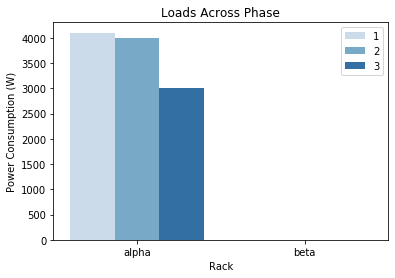

In [26]:
sns.barplot(x='Rack',y='Load',hue='Phase',data=data,palette='Blues')
plt.title('Loads Across Phase')
plt.xlabel('Rack')
plt.ylabel('Power Consumption (W)')
plt.show()

In [27]:
grouped = df.groupby('Rack')
diff = grouped['Load'].max() - grouped['Load'].min()

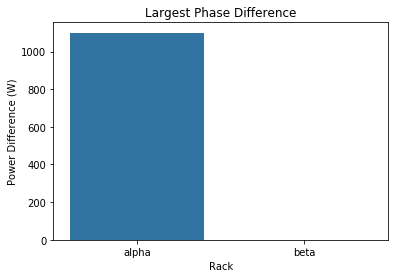

In [28]:
sns.barplot(x=diff.index,y=diff.values)
plt.title('Largest Phase Difference')
plt.ylabel('Power Difference (W)')
plt.show()